# This notebook is meant to study effects that depends on the lifetime

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters, likelihood_levels_1d
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis

In [3]:
hierarchy = 'heavy'
D_or_M = 'dirac'
save_folder = (f'../fig/4_analysis_variables_plots/')
!mkdir -p $save_folder
save_folder = (f'../fig/4_analysis_variables_plots/{hierarchy}_{D_or_M}_')

set_plot_style()

## Use this to load the datasets in the usual way and dump them in pickle files

In [4]:
# my_exp_analyses = load_datasets(hierarchy, D_or_M, 
#                                 timeit=True, 
#                                 direct_load_objects=False,
#                                 dump=True,
#                                 load_grid=False)

## Use the function this way to load the datasets from the pickle files

In [5]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=True,
                                load_grid=False)

heavy dirac FHC
Wall time: 11.378021478652954 s, CPU time: 1.2641402409999998
heavy dirac RHC
Wall time: 2.9567365646362305 s, CPU time: 0.6865905350000006


# Detector plot

In [7]:
from parameters_dict import *
aux_binning = []
for splits in detector_splitting_z.values():
    aux_binning += np.linspace(*splits, 10).tolist()
binning_z = np.array(aux_binning)

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/numpy/lib/histograms.py:1122: RuntimeWarning: invalid value encountered in true_divide
  hist = hist / dedges[i].reshape(shape)


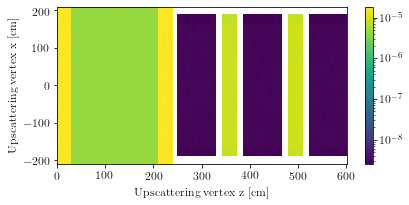

In [12]:
nu_mode = 'FHC'
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']
df = exp_analysis_obj.df_base

this_weights = exp_analysis_obj.compute_pot_ntarget_weights(df, 
                            ntarget_per_material=analyses['tpc'][nu_mode]['n_target'],
                            pot=analyses['tpc'][nu_mode]['pot'])


fig = plt.figure(figsize=(6.5,2.9))
plt.hist2d(df['int_point_z'], df['int_point_x'], 
           bins=(binning_z, np.linspace(*detector_splitting_x[0], 20)), 
           weights=this_weights, norm=LogNorm(),
           density=True);
plt.xlabel('Upscattering vertex z [cm]')
plt.ylabel('Upscattering vertex x [cm]')
plt.colorbar()

plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

In [14]:
# ctaus = np.array([0.5, 0.2, 0.1])
ctaus = np.array([100, 1, 0.01])

nu_mode = 'FHC'
aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=ctaus,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

aux_noctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=None,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


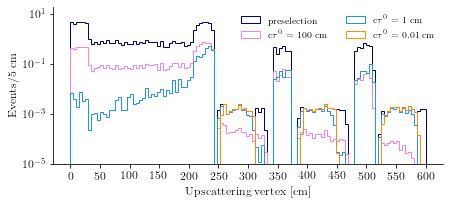

In [7]:
fig = plt.figure(figsize=(7,2.9))

binning = np.linspace(0, 600, 120)
bin_width = binning[1]-binning[0]

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.hist(aux_noctau[0]['int_point_z'],
         bins=binning,
         weights=aux_noctau[1]/bin_width,
         histtype='step',
         color='navy',
         label='preselection')

colors = ['violet', 'dodgerblue', 'darkorange']
for i, ctau in enumerate(ctaus):
    plt.hist(aux[0]['int_point_z'],
             bins=binning,
             weights=aux[1][:, i]/bin_width,
             histtype='step',
             color=colors[i],
             label=f'c$\\tau^0$ = {ctau:.3g} cm')
plt.legend(frameon=False, ncol=2)
plt.yscale('log')
plt.ylim(1e-5, 2e1)
plt.ylabel(f'Events/{bin_width:.2g} cm')
plt.xlabel('Upscattering vertex [cm]')
plt.xticks(np.linspace(0, 600, 13));
# plt.savefig(save_folder+f'int_vertex_z.pdf', bbox_inches='tight')

# Find the c$\tau$ we exclude by varying $V_{ND}$

In [12]:
V_N_2_s = np.geomspace(physics_parameters['heavy']['bp']['Umu4_2'], 1e2, 25)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['Ud4_2'] = V_N_2_s

ctaus = ctau_heavy(m4=this_point['m4'],
                   mz=this_point['mz'], 
                   Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
                   D_or_M=D_or_M)

leff = np.zeros(V_N_2_s.shape)
mu_s = np.zeros(V_N_2_s.shape)
sigma2_s = np.zeros(V_N_2_s.shape)
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=True)
    leff += aux[0]
    mu_s += aux[1]
    sigma2_s += aux[3]

leff -= leff.min()

In [13]:
like_interp = interp1d(ctaus, leff-likelihood_levels_1d[0.9], kind='cubic')
r1 = root_scalar(like_interp, method='brentq', bracket=[1e-2, 1], 
                 fprime=None, fprime2=None, x0=0.2, x1=0.15)
r2 = root_scalar(like_interp, method='brentq', bracket=[1e3, 1e5], 
                 fprime=None, fprime2=None, x0=1e4, x1=2e4)

In [14]:
print(r1.root)

0.23799036924571193


(-1.0, 1.0)

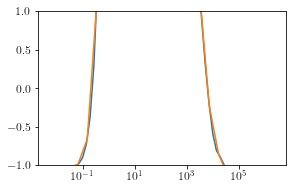

In [15]:
plt.plot(np.geomspace(1e-2, 1e5, 50), like_interp(np.geomspace(1e-2, 1e5, 50)))
plt.plot(ctaus, leff-likelihood_levels_1d[0.9])
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1, 1)

<ipython-input-16-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


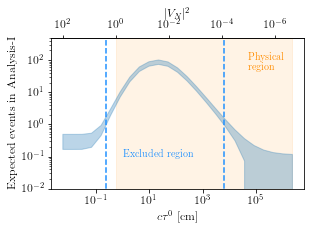

In [16]:
from scipy.interpolate import UnivariateSpline

ax = set_canvas_basic()
ax.set_xlabel('$c\\tau^0$ [cm]')
ax.set_ylabel('Expected events in Analysis-I')
ax.set_xscale('log')
ax.set_yscale('log')

forward_fun = UnivariateSpline(np.log(ctaus[::-1]), np.log(V_N_2_s[::-1]), k=1)
backward_fun = UnivariateSpline(np.log(V_N_2_s), np.log(ctaus), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$|V_N|^2$')
secax.set_ticks

ax.fill_betweenx([1e-2, 1e4], 
                 backward(physics_parameters['heavy']['bp']['Umu4_2']), backward(1), 
                 color='darkorange', alpha=0.1)
ax.annotate('Physical\n region', color='darkorange', xy=(5e4, 5e1))

ax.fill_between(ctaus, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
                color='C0', alpha=0.3, label='number of events')
ax.vlines(r1.root, 0, 1e4, color='dodgerblue', ls='--')
ax.vlines(r2.root, 0, 1e4, color='dodgerblue', ls='--')
ax.annotate('Excluded region', color='dodgerblue', xy=(1, 1e-1))
ax.set_ylim(1e-2, 5e2)

plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.pdf', bbox_inches='tight')
plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.png', bbox_inches='tight', transparent=True, dpi=500)

## for different $m_N$

In [6]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] = 1e-20

base_like = 0
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base,
                                     **this_point, 
                                     analysis=analyses['tpc'][nu_mode], 
                                     like_normalized=False)
    base_like += (-aux[0])

In [7]:
def get_ctau0_min(this_point, base_like):
    aux = {}
    for nu_mode in ['FHC', 'RHC']:
        aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                     **this_point, 
                                     analysis=analyses['tpc'][nu_mode], 
                                     like_normalized=False)

    leff = aux['FHC'][0] + aux['RHC'][0]
    # mu_s = aux['FHC'][1] + aux['RHC'][1]
    # sigma2_s = aux['FHC'][3] + aux['RHC'][3]
    leff *= -1
    leff -= base_like
    
    like_interp = interp1d(this_point['external_ctau'], 
                           leff-likelihood_levels_1d[0.9], 
                           kind='cubic')
    print(this_point['external_ctau'])
    print(leff-likelihood_levels_1d[0.9])
    return root_scalar(like_interp, method='brentq', 
                          bracket=[this_point['external_ctau'][0], this_point['external_ctau'][-1]], 
                          fprime=None, fprime2=None, x0=(this_point['external_ctau'][0]+this_point['external_ctau'][-1])/2).root

In [8]:
m4_s = np.linspace(0.01, 0.2, 20)
ctau_min_s = []
for m4 in m4_s:
    print(m4)
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['m4'] = m4
    this_point['external_ctau'] = np.geomspace(0.001, 5, 20)
    for i in range(1, 2):
        ctau_min = get_ctau0_min(this_point, base_like)
        print(ctau_min)
        this_point['external_ctau'] = np.geomspace(ctau_min/(1+1/i**2), ctau_min*(1+1/i**2), 20)
        
    ctau_min_s.append(ctau_min)

0.01
[1.00000000e-03 1.56560656e-03 2.45112389e-03 3.83749564e-03
 6.00800835e-03 9.40617727e-03 1.47263728e-02 2.30557058e-02
 3.60961643e-02 5.65123915e-02 8.84761707e-02 1.38518873e-01
 2.16866056e-01 3.39526920e-01 5.31565572e-01 8.32222546e-01
 1.30293308e+00 2.03988057e+00 3.19365039e+00 5.00000000e+00]
[-0.92003622 -0.91979399 -0.9192213  -0.91736423 -0.90602045 -0.85429749
 -0.68627614 -0.22990789  0.8156635   2.73054917  6.18881346 12.31969906
 21.35419059 31.34899079 39.93114123 46.30315445 50.72714063 53.0973351
 52.79808015 49.54273159]
0.026278714577272624
0.02
[1.00000000e-03 1.56560656e-03 2.45112389e-03 3.83749564e-03
 6.00800835e-03 9.40617727e-03 1.47263728e-02 2.30557058e-02
 3.60961643e-02 5.65123915e-02 8.84761707e-02 1.38518873e-01
 2.16866056e-01 3.39526920e-01 5.31565572e-01 8.32222546e-01
 1.30293308e+00 2.03988057e+00 3.19365039e+00 5.00000000e+00]
[-0.90187892 -0.90177124 -0.90145417 -0.90089163 -0.89993249 -0.89554782
 -0.87251441 -0.7861481  -0.51751218  0.

In [9]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

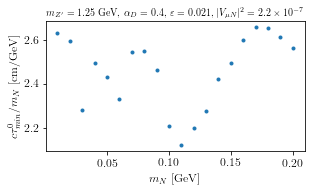

In [10]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)

ax.plot(m4_s,
         ctau_min_s/m4_s, 
         '.')
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min} /m_N$ [cm/GeV]')
set_plot_title(ax, 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_div_mn_vs_mn.pdf')

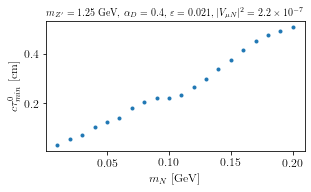

In [11]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)

ax.plot(m4_s,
         ctau_min_s, 
         '.')
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(ax, 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn.pdf')

In [75]:
mz_s = np.linspace(1, 2, 3)
m4_s = np.linspace(0.01, 0.2, 3)
ctau_min_s = []

In [76]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

for mz in mz_s:
    this_point['mz'] = mz
    print(f'mz = {mz}')
    ctau_min_s.append([])
    for m4 in m4_s:
        print(f'm4 = {m4}')
        this_point['m4'] = m4
        this_point['external_ctau'] = np.geomspace(0.001, 10, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        
        ctau_min_s[-1].append(ctau_min)

mz = 1.0
m4 = 0.01
[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
[-0.30663739 -0.30469951 -0.3014361  -0.28232379 -0.1713907   0.32385313
  1.81990605  4.90268    10.2773372  19.83738831 34.98031378 52.94910405
 69.10817452 81.02280027 89.05173607 94.34996948 96.69212032 94.95040236
 88.76763849 78.92179037]
[0.00444277 0.00477905 0.00514078 0.00552988 0.00594844 0.00639869
 0.00688301 0.00740398 0.0079644  0.00856723 0.00921568 0.00991323
 0.01066356 0.01147069 0.01233892 0.01327286 0.01427749 0.01535816
 0.01652063 0.01777108]
[-0.27886947 -0.27053487 -0.25972128 -0.24576755 -0.22785472 -0.20497756
 -0.17591662 -0.13921445 -0.09315998 -0.03578688  0.03510899  0.1219289
  0.22720657  0.35352402  0.50341743  0.6792869   0.88332411

In [78]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['mz'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

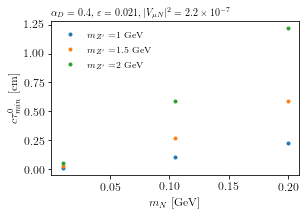

In [80]:
for i, mz in enumerate(mz_s):
    plt.plot(m4_s,
             ctau_min_s[i], 
             '.',
             label=r'$m_{Z^{\prime}}$ = '+f'{mz:.3g} GeV')
    
plt.legend(frameon=False)
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn_mz.pdf', bbox_inches='tight')

## Varying V_muN

In [88]:
Umu4_2_s = [2e-8, 1e-7, 5e-7]
m4_s = np.linspace(0.01, 0.2, 3)
ctau_min_s = []

In [90]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

for Umu4_2 in Umu4_2_s:
    this_point['Umu4_2'] = Umu4_2
    print(f'Umu4_2 = {Umu4_2}')
    ctau_min_s.append([])
    for m4 in m4_s:
        print(f'm4 = {m4}')
        this_point['m4'] = m4
        this_point['external_ctau'] = np.geomspace(0.001, 10, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        
        ctau_min_s[-1].append(ctau_min)

Umu4_2 = 2e-08
m4 = 0.01
[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
[-1.30944584 -1.30957986 -1.30972962 -1.30955667 -1.30575157 -1.28376917
 -1.21102335 -1.04714914 -0.7412019  -0.14488549  1.07847667  3.11986119
  5.63008451  7.85123903  9.40069017 10.34188305 10.61890805 10.00249697
  8.50494359  6.49708658]
[0.04243187 0.04564356 0.04909835 0.05281464 0.05681221 0.06111236
 0.06573799 0.07071373 0.0760661  0.08182358 0.08801686 0.09467891
 0.10184521 0.10955393 0.11784613 0.12676598 0.13636097 0.14668221
 0.15778467 0.16972749]
[-0.84257937 -0.78790351 -0.72765633 -0.6610637  -0.58723025 -0.50514051
 -0.41366637 -0.31158156 -0.19758391 -0.0703256   0.07154884  0.22935748
  0.40433015  0.59755345  0.82760316  1.06105799  1.3

In [92]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

In [94]:
ctau_min_s

[[],
 [0.08491952405258103, 0.8923183303210169, 1.881067492078531],
 [0.027742591261226305, 0.31031759665909164, 0.6133165629715931],
 [0.008539613004478667, 0.11520381807737003, 0.2483787411900989]]

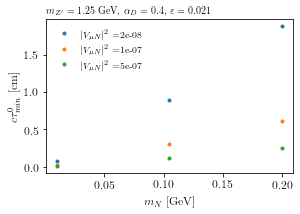

In [96]:
for i, Umu4_2 in enumerate(Umu4_2_s):
    plt.plot(m4_s,
             ctau_min_s[i+1], 
             '.',
             label=r'$|V_{\mu N}|^2$ ='+f'{Umu4_2:.3g}')
    
plt.legend(frameon=False)
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn_Umu4_2.pdf', bbox_inches='tight')

# Geometrical acceptance

In [6]:
ctaus = np.geomspace(1e-2, 1e4, 20)

mu_s = {}
sigma2_s = {}

mu_s_noctau = {}
sigma2_s_noctau = {}

materials = ['lead', 'argon']
for selection in materials:
    mu_s[selection] = 0
    sigma2_s[selection] = 0
    mu_s_noctau[selection] = 0
    sigma2_s_noctau[selection] = 0
    for nu_mode in ['FHC', 'RHC']:
        aux = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=ctaus,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s[selection] += aux[1].sum(axis=0)
        sigma2_s[selection] += (aux[1]**2).sum(axis=0)
        
        aux_noctau = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=None,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s_noctau[selection] += aux_noctau[1].sum(axis=0)
        sigma2_s_noctau[selection] += (aux_noctau[1]**2).sum(axis=0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


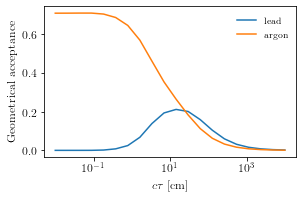

In [7]:
ax = set_canvas_basic()

for selection in materials:     
    ax.plot(ctaus, mu_s[selection]/mu_s_noctau[selection], label=selection)

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.legend(frameon=False, loc='upper right')


# plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
# plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)